# Clustering y PCA sobre dataset de work-life balance

## Laboratorio 2022 - Tarea 4

### Grupo 27

Alexis Baladón, CI: 5.574.612-4

Ignacio Viscardi, CI: 5.066.666-2

Rafael Castelli, CI: 5.079.391-2

## Requisitos para reproducción de algoritmo

Para correr el presente notebook se deberán instalar las siguientes dependencias. Queda un script para su instalación automática.

In [ ]:
!pip install -r requirements.txt

## 2. Decisiones de diseño

La finalidad de esta sección consiste en introducir las principales decisiones de diseño tomadas para esta implementación de K-means.

### 2.1 Preprocesado

Primeramente, se elimina el nombre de la ciudad y país del conjunto de datos. Esto se hace debido a que ambos son atributos categóricos, por lo que sería necesaria una técnica como one-hot encoding para trabajar sobre ellos, pudiendo tener efectos indeseados al calcular la distancia euclídea (especialmente al normalizar los datos) debido a la maldición de la dimensionalidad. Más aún, no fueron considerados relevantes para medir el work-life balance.
Por otra parte, también se eliminó la columna 2021 y 2022 ya que estos atributos no parecen ser relevantes para el problema en cuestión, además de ser identificadores únicos de cada tupla.

En la seccion 3 (Experimentación) se mencionarán, cuando se considere adecuado, otras variables que fueron eliminadas del conjunto de datos para realizar los experimentos pertinentes.

### 2.2 Metaparametros

-- explicar los metaparametros

### 2.3 Metodo de inicialización
Se consideraron 2 métodos de inicialización para los centroides del algoritmo K-means. 
Uno de los métodos realiza una selección aleatoria de K elementos del espacio de posibles elementos (se considera que un elemento x esta en el espacio de posibles elementos si para cada coordenada su valor es menor o igual que el maximo valor, en valor absoluto, que puede tomar dicha coordenada en el dataset provisto).

El otro método de inicialización considerado consiste en tomar k elementos del dataset (al azar) como centroides iniciales. Según lo visto en el teórico del curso, este método debería tener mejores propiedades de convergencia y ser menos propenso a dejar clusters vacios durante la ejecución.

#TODO: demostrar convergencia de ambos métodos (aclaracion, agregar graficas en la que se note eso, y tirar un comentario asi noma)

### 2.4 Manejo de cluster vacios en kmeans
Dado que el algoritmo k-means presentado en el curso no contempla el caso de generar cluster vacios, entonces fue necesario agregar cierta logica al algoritmo de modo que esto no ocurra.
Lo que se hizo para solventar ese problema fue chequar en cada iteración del algoritmo, luego de asignar los elementos a los clusters, si alguno de los clusters quedaba vacio. En caso de que esto ocurriera, se procedia a reasignar los centroides vacios de modo de que el cluster que forma contenga al menos un elemento. Luego de esto se volvió a asignar los elementos a los clusters, y en caso de que el problema anterior ocurriera devuelta entonces se vuelve a realizar la técnica antes mencionada hasta que el problema ya no este presente. 
Una vez no tengo clusters vacios se procede con el algoritmo como corresponde.

Notese que la técnica utilizada para reasignar los centroides consistió en tomar el elemento del dataset mas cercano al centroide del cluster vacio y asignar dicho elemento como nuevo centrodide del cluster. De esta manera nos aseguramnos de que el cluster contenga al menos un elemento.

## 3 Experimentos

Para la experimentación, se considera el conjunto de datos sin normalizar y luego normalizado, de forma de contrastar el efecto que la normalización puede tener en el algoritmo kmeans. Dado que la mayoría de los datos están en una escala de 0 a 100, y aquellos que no están, tampoco tienen escalas muy distintas, entonces parece razonable empezar sin normalizar los datos, para evitar perturbaciones a la varianza y los clusters producidos.

En lo que sigue, se distinguen 3 casos del conjunto de datos: original_df corresponde al conjunto de datos tal cual se carga directamente del CSV, sin realizarle ningún preprocesado. Dicho objeto se utiliza para encontrar a Montevideo (y potencialmente otras ciudades) dentro de los datos. minimal_preprocess_df corresponde al conjunto de datos donde el único preprocesado que se hace es eliminar las columnas nombradas en la sección 2.1 y eventualmente la normalización de los datos. Por último df corresponde al dataset con donde se eliminan todas las columnas que se consideraron irrelevantes dado el análisis del dataset.

Vale la pena aclarar que para los experimentos realizados en los que se utiliza el metodo del codo y silhouette, se tomaron los datos a partir del promedio de los resultados obtenidos al correr los experimentos con distintas semillas las cuales son utilizadas por el generador de números aleatorios, debido a que k-means es una técnica estocástica.

### 3.1 Sin normalizacion


Prerequisitos:

Antes de correr todos los test que siguen, es necesario correr esta celda de código con el fin de cargar algunas variables que serán reutilizadas a lo largo de la experimentación.

In [2]:
import preprocessing
import constants
import os
from test import Test

original_df = preprocessing.load_csv()
minimal_preprocess_df = preprocessing.minimal_preprocess(original_df)
df = preprocessing.preprocess(original_df, shouldNormalize=False)
test = Test()
k_values = list(range(1, constants.MAX_K_PLUS_1))

Análisis de valores propios

Para tener una idea del número de dimensiones relevantes y por panto una potencial pista del número de columnas irrelevantes de las cuales se puede prescindir, se grafican los valores propios para ver las magnitudes de los mismos y compararlas. Se empieza con una escala lineal.

Eigenvalues (Escala lineal)

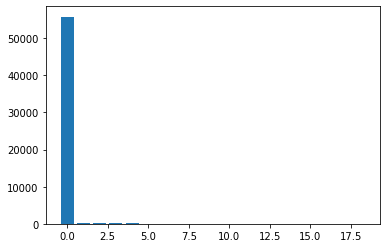

In [3]:
test.PCA_eigen_values(minimal_preprocess_df, scale="linear", drop_first=False)

Claramente la escala lineal muestra que existe un valor propio que domina ámpliamente a los demás. Para poder apreciar mejor el comportamiento de los demás valores propios, se repite el experimento sin considerar el primer valor propio. Como adjunto se grafican los valores propios en escala logaritmica.

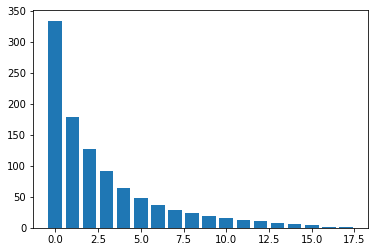

In [6]:
test.PCA_eigen_values(minimal_preprocess_df, scale="linear", drop_first=True)

Claramente se tiene un valor propio ampliamente dominante sobre el resto, y el segundo valor propio más grande es aproximadamente 2 veces el tercer valor propio más grande. Luego, se concluye que existe lugar para descartar algunas columnas (se visualiza mejor al analizar la matríz de covarianza), y es claro que se deben conservar al menos 2 o 3 dimensiones. Luego, empieza a ser discutible donde se puede realizar el punto de corte para dejar de descartar dimensiones.

Se recuerda que dichas dimensiones (las dadas por PCA) no se corresponden directamente con las dimensiones del conjunto de datos original pero puede dar una idea sobre la importancia relativa de las distintas dimensiones.

No obstante, en este caso no resulta extremadamente evidente las conclusiones que se puedan sacar.

Eigenvalues (Escala logaritmica)

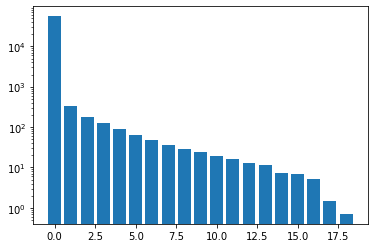

In [5]:
test.PCA_eigen_values(minimal_preprocess_df, scale="log", drop_first=False)

Para continuar con la selección de atributos, se analiza la covarianza entre los distintos atributos. Particularmente, ya que es de interés analizar la interdependencia de los distintos atributos y no tanto si un atributo influye positivamente o negativamente sobre otro, se toma el valor absoluto de la covarianza para facilitar el análisis visual.

covariance_matrix

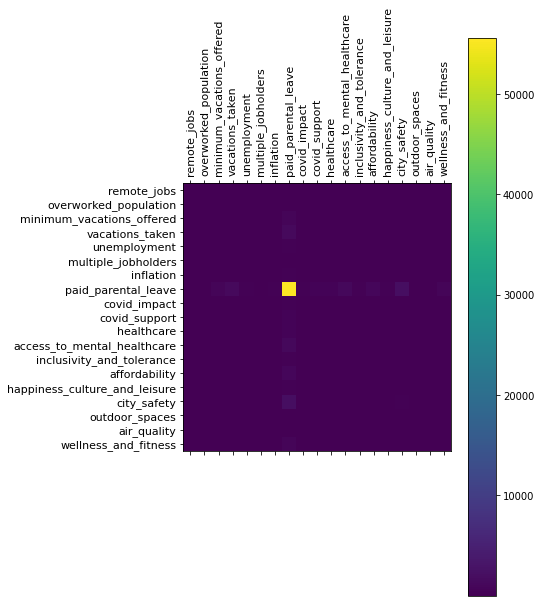

In [7]:
test.abs_covariance_matrix(minimal_preprocess_df)

Como ilustra la imagen anterior, las escalas de la matriz de covarianza no facilitan el análisis visual de la situación. Por esto, se utiliza el valor absoluto de la correlación.

correlation matrix

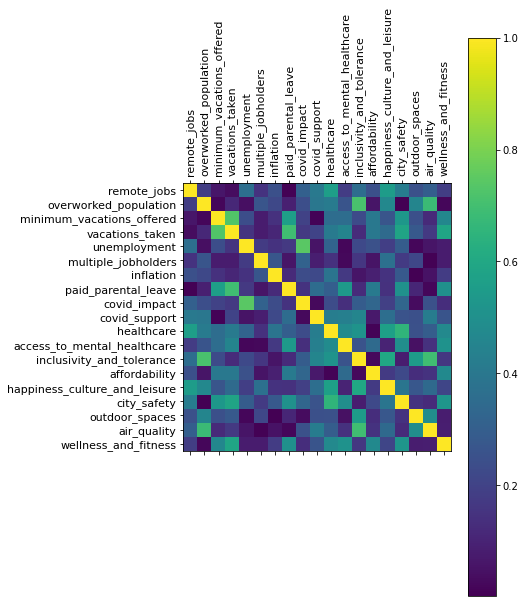

In [8]:
test.abs_correlation_matrix(minimal_preprocess_df)

Gráficamente la situación mejora, ahora se distinguen atributos que están claramente correlacionados, como "minimun_vacations_offered" y "vacations_taken". Algunas de estas correlaciones parecen muy intuitivas (como la anterior) y otras pueden ser discutibles.

A continuación se presenta la matriz de correlación absoluta que se obtiene luego de la selección de atributos. Luego se presenta una herramienta utilizada para la selección de atributos y por último se da una explicación de la selección realizada. Como estrategia general, dados dos atributos A1 y A2, se intenta eliminar uno de los dos si ambos están muy correlacionados (positiva o negativamente) pues es esperable que no aporten mucha información adicional y removerlos contribuye a reducir la dimensionalidad del dataset y potencialmente mejorar la calidad de las técnicas aplicadas. Notar que en esta estrategia no se consideran correlaciones entre 3 o más atributos conjuntamente.

Correlation matrix (non minimal)

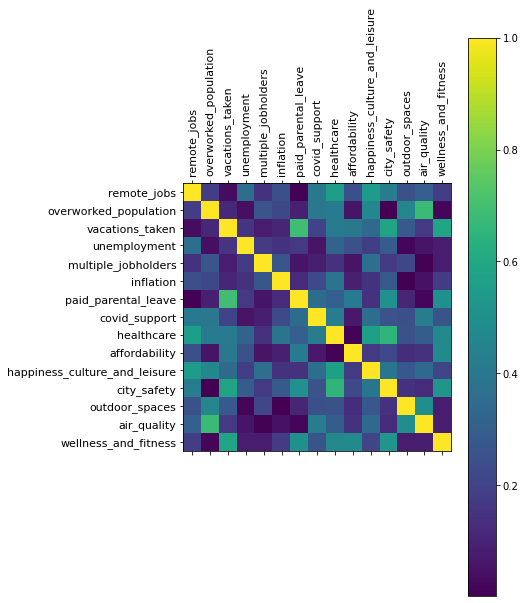

In [9]:
test.abs_correlation_matrix(df)

Como otra herramienta utilizada, se utiliza la misma matriz de correlación absoluta pero filtrada con un punto de corte tal que: si xij > punto de corte entonces xij <- 1 en otro caso xij <- 0.

Esto facilita la visualización de atributos altamente correlacionados, dismunuyendo gradualmente el punto de corte y observando en "orden de importancia" relaciones entre los datos.

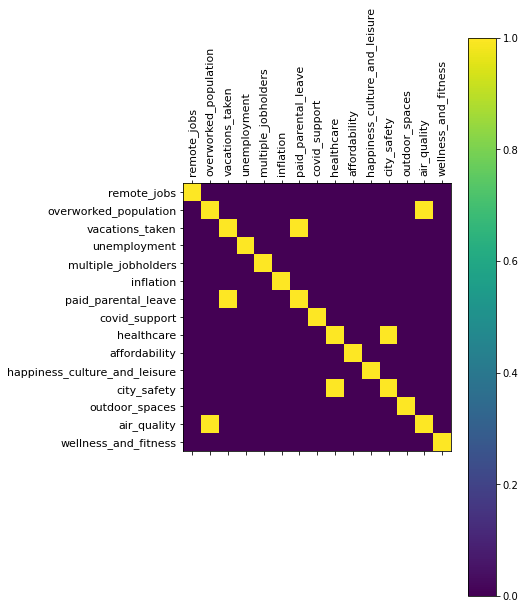

In [10]:
test.cutpoint_abs_correlation_matrix(df, cutpoint=0.60)

Es esperable que los atributos "healthcare" y "access_to_mental_healthcare" estén relacionados. Viendo la matriz de covarianza se confirma esta hipótesis. Dado que se puede considerar "mental_healthcare" dentro de "healthcare", se decide eliminar la columna "access_to_mental_healthcare" y quedarse solo con "healthcare".

Por otro lado, parece bastante razonable tener una correlación entre "minimun_vacations_offered" y "vacations_taken". Nuevamente la matriz de covarianza confirma la hipótesis por lo que se puede considerar como "redundante" a una de ambas columnas. Intuitivamente se considera que para el balance entre vida privada y trabajo, es más relevante el numero de vacaciones que efectivamente se toman respecto a las que se ofrecen, por lo que se elimina "minumun_vacations_offered" y se mantiene "vacations_taken".

Utilizando la matriz con el punto de corte 0.7, se observa una fuerte correlación entre "covid_impact" y "unemployment". Como se considera más relevante para el problema presenta los niveles de desempleo y también se puede argumentar (especialemente considerando la correlación entre ambos atributos, que demuestra como dentro de los factores computados dentro de "covid_impact" el desempleo o la economía es de los más ponderados) que "unemployment" es un "atributo más general", de forma análoga como se hizo con "healthcare". Luego, se preserva "unemployment" sobre "covid_impact".
Por último se observa que "inclusivity_and_tolerance" tienen una correlación de más de 0.6 con "overworked_population", lo que puede ser indicio de que uno de los atributos es "redundante". Por otro lado, "inclusivity_and_tolerance" intuitivamente no parece tener mucho que ver (al menos a grandes razgos) con el balance vida-trabajo, mientras que la población que tiene que trabaja de más claramente está relacionada con la temática. En virtud de esto, se elimina la columna "inclusivity_and_tolerance".
Luego de este análisis, se consiguen resultados relativamente claros en el método del codo, así como el análisis del coeficiente de Silhouette y en la visualización por PCA de los clusters y por tanto se decide dejar de eliminar atributos.

Silhouette

A continuación se grafica el coeficiente de Silhouette respecto al número de clusters.

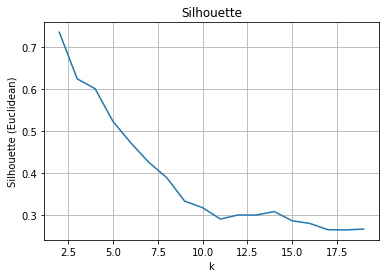

In [3]:
k_values = [x for x in range(2, constants.MAX_K_PLUS_1)]
test.test_silhouette(k_values=k_values, dataset=df, cpu_count=os.cpu_count())

Viendo la gráfica, se desprende que el número óptimo de clusters es 2 dado que alli es donde toma el valor máximo.

Elbow method

Aquí se utiliza el método del codo para tratar de determinar el número óptimo de clusters.

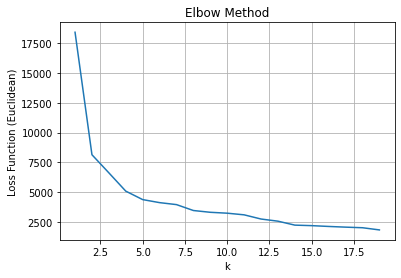

In [4]:
k_values = [x for x in range(1, constants.MAX_K_PLUS_1)]
test.test_elbow_method(dataset=df,k_values=k_values,cpu_count=os.cpu_count())

De la gráfica se desprende que 2 es un posible número de clusters óptimos, coincidiendo con Silhouette. Por otro lado, se puede cuestionar si 4 parece un número razonable de clusters, especialmente cuando se lo grafica utilizando PCA. Como ambos números parecen posibles candidatos, pero 2 es confirmado por ambos métodos, por defecto se concluye que 2 es el número óptimo de clusters. No obstante, gráficamente se puede ver la competividad que tienen 2 y 4 como número óptimo de clusters, e incluso se podría considerar al 3.

PCA 2D

Se adjuntan en esta sección la gráfica de los clusters en 2 dimensiones utilizando PCA

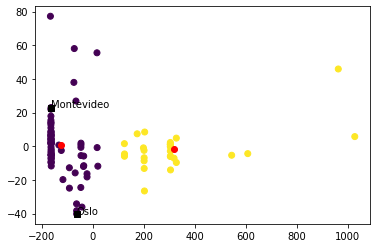

In [3]:
import preprocessing
import constants
from test import Test


original_df = preprocessing.load_csv()
#df = preprocessing.minimal_preprocess(original_df)
df = preprocessing.preprocess(original_df, shouldNormalize=False)
test = Test()
test.PCA_graph(df,original_df,dimensions=2,number_of_clusters=2)

Dado que en el listado Montevideo aparece en un lugar bastante malo, se puede concluir que el cluster al cual pertenece Montevideo es el cluster de aquellas ciudades con un mal balance entre vida privada y trabajo. Para corroborar la hipótesis, se ubica a Bern (la segunda mejor ciudad en el listado) y aparece en el mismo cluster que Montevideo. Esto parece bastante poco razonable. Considerando los datos con el preprocesado mínimo definido, la situación no cambia. Por su parte, Oslo (la mejor ciudad del listado) queda en el otro cluster.

Esto da a entender que o el número de clusters no es el apropiado (con 4 clusters Bern se posiciona en un cluster distinto a Montevideo) o que el dataset contiene ruido. La segunda conclusión, puede verse apoyada en algunas de las extrañas correlaciones entre algunos de los atributos, como la relación entre "air_quality" y "inclusivity_and_tolerance". Por otro lado, el conjunto de datos tiene algunos datos con valores 0, donde no tiene sentido, por ejemplo, segun el dataset se toman 0 vacaciones en Montevideo (ver columna "vacations_taken" en Montevideo).

Para indagar un poco más sobre lo sucedido, se imprimen todas las ciudades (y su ranking según la tabla original) que pertenecen al mismo cluster que Montevideo 

In [5]:
import preprocessing
import constants
import os
import pandas as pd
from test import Test
from k_means import KMeans

original_df = preprocessing.load_csv()
minimal_preprocess_df = preprocessing.minimal_preprocess(original_df)
df = preprocessing.preprocess(original_df, shouldNormalize=False)

test = Test()
k_values = list(range(1, constants.MAX_K_PLUS_1))

cities = test.get_cities_in_the_same_cluster(original_df, df, city = "Montevideo", country = "Uruguay", clusters=2)
with pd.option_context('display.max_rows', 100):
    print(cities)

1                 Bern
3               Zurich
5               Geneva
7               Sydney
11           Melbourne
12           Amsterdam
16            Auckland
28                Graz
31             Seattle
32            Portland
34         Minneapolis
35      Salt Lake City
36              Dublin
37              Boston
38       San Francisco
40          Washington
41              Madrid
42               Omaha
43           San Diego
44           Singapore
45              Denver
46      Virginia Beach
47             Raleigh
48          Sacramento
49           Barcelona
51          Des Moines
52            Honolulu
54    Colorado Springs
55               Tampa
56         Kansas City
57           Charlotte
58            New York
59             Atlanta
60           Milwaukee
61              Austin
63          Pittsburgh
64        Jacksonville
65           Nashville
66          Cincinnati
67            Columbus
68             Chicago
69               Miami
70           Baltimore
71        P

El conjunto contiene 72 elementos y corresponde a la gran agrupación de puntos que se encuentra a la derecha de la gráfica de los clusters. Claramente el conjunto tiene un amplio rango de ciudades en distintas posiciones del ranking y no se puede atribuir al cluster como aquellas ciudades con mal balance entre vida privada y trabajo.

Dada la gran agrupación de puntos, puede ser que normalizar ayude en este caso.

### 3.2 Con normalización

A continuación se presentarán los mismos expermientos que fueron realizados en la sección 3.1 pero esta vez utilizando el dataset normalizado.

In [8]:
import preprocessing
import constants
import os
from test import Test

original_df = preprocessing.load_csv()
minimal_preprocess_df = preprocessing.minimal_preprocess(original_df)
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()
k_values = list(range(1, constants.MAX_K_PLUS_1))

In [9]:
k_values = [x for x in range(2, constants.MAX_K_PLUS_1)]
test.test_silhouette(k_values=k_values, dataset=df, cpu_count=os.cpu_count())

KeyboardInterrupt: 

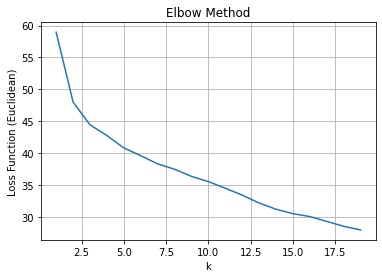

In [10]:
import preprocessing
import constants
import os
from test import Test


original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()
k_values = [x for x in range(1, constants.MAX_K_PLUS_1)]
test.test_elbow_method(dataset=df,k_values=k_values,cpu_count=os.cpu_count())

#3.3 Visualización con PCA

PCA es un método de reducción de dimensionalidad haciendo uso de la covarianza entre los atributos del conjunto de datos con el fin de reducir solo las dimensiones que menos la afecten.

#3.3.1 PCA 2D

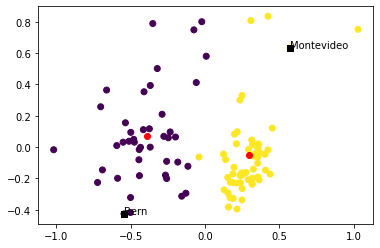

In [15]:
import preprocessing
import constants
from test import Test


original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()
test.PCA_graph(df,original_df,dimensions=2,number_of_clusters=2)

Analizando estos resultados se ve con claridad que existen puntos que aparentan pertenecer a distintos clusters. En particular, existe un conjunto de datos del lado izquierdo que parecen estar altamente relacionados, lo cual el algoritmo logra captar agrupando a todos. Por otro lado, se agrupa en otro cluster a ciudades que parecen estar relacionadas (aunque no tanto como en el conjunto antes mencionado), además de agrupar a datos que parecerían ser ruidosos. Esto parece indicar que el algoritmo logra cumplir con su objetivo, al igual que da a conocer propiedades difíciles de ver a simple vista.

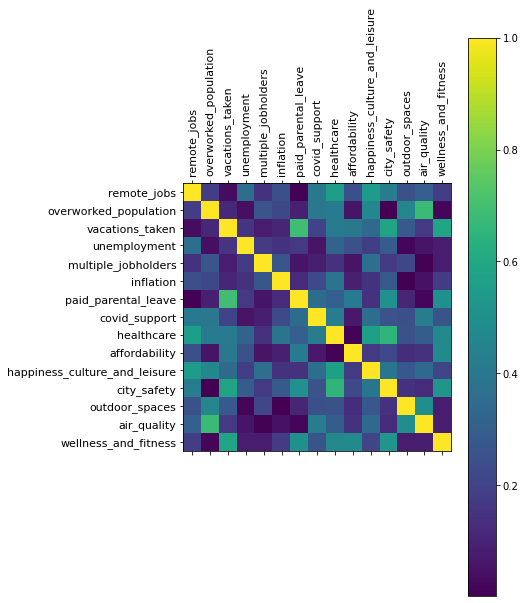

In [5]:
test.abs_correlation_matrix(df)

In [7]:
import preprocessing
import constants
import os
import pandas as pd
from test import Test
from k_means import KMeans

original_df = preprocessing.load_csv()
minimal_preprocess_df = preprocessing.minimal_preprocess(original_df)
df = preprocessing.preprocess(original_df, shouldNormalize=True)

test = Test()
k_values = list(range(1, constants.MAX_K_PLUS_1))

cities = test.get_cities_in_the_same_cluster(original_df, df, city = "Montevideo", country = "Uruguay", clusters=2)
with pd.option_context('display.max_rows', 100):
    print(cities)

31             Seattle
32            Portland
34         Minneapolis
35      Salt Lake City
37              Boston
38       San Francisco
40          Washington
42               Omaha
43           San Diego
45              Denver
46      Virginia Beach
47             Raleigh
48          Sacramento
50              Lisbon
51          Des Moines
52            Honolulu
54    Colorado Springs
55               Tampa
56         Kansas City
57           Charlotte
58            New York
59             Atlanta
60           Milwaukee
61              Austin
63          Pittsburgh
64        Jacksonville
65           Nashville
66          Cincinnati
67            Columbus
68             Chicago
69               Miami
70           Baltimore
71        Philadelphia
72        Indianapolis
73              Tucson
74           Cleveland
75       Oklahoma City
76              Dallas
77         Los Angeles
78             Phoenix
79         San Antonio
80               Tulsa
81             Wichita
82         

Normalizando los datos, se obtienen resultados más razonables respecto a la relación entre los clusters y la posición que se les asigna en el conjunto de datos original.

#3.3.2 PCA 3D

Se analiza adicionalmente la versión tridimensional de PCA, la cual tiene la ventaja de la bidimensional en cuanto a su fácil visualización además de la menor pérdida de información.

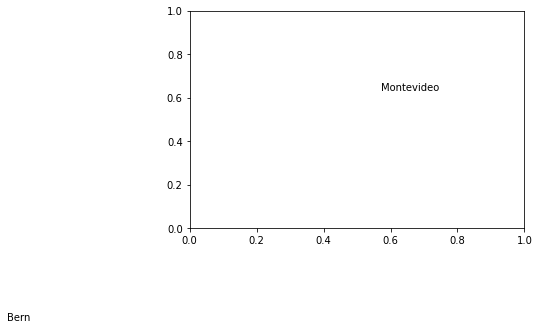

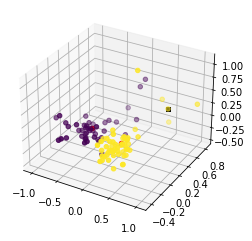

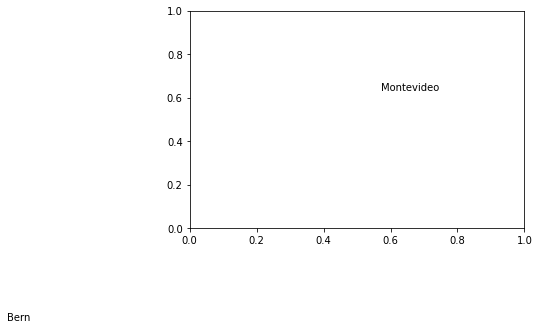

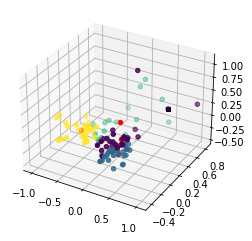

In [8]:
import preprocessing
import constants
from test import Test


original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()
for  cluster_k in [2,4]:
    test.PCA_graph(df,original_df,dimensions=3,number_of_clusters=cluster_k)

In [ ]:
import preprocessing
import constants
from test import Test


original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()

Al estudiar los datos en tres dimensiones no parece haber mucha diferencia, 

## 4 Conclusiones

## 4.1 Resultados según expectativas iniciales
 Joya